# Analysis of short 20 sec Power Spectra

In [1]:

import plotly
import plotly.graph_objs as go

# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz

import seaborn as sns
import pingouin as pg
from itertools import combinations
from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv
import h5py
import fooof
from fooof.plts.spectra import plot_spectrum

#mne
from pathlib import Path
import mne_bids
from mne_bids import (
    BIDSPath,
    inspect_dataset,
    mark_channels)
import mne
from mne.time_frequency import tfr_morlet 

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [58]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'Monopolar_power_estimation', 'monopolar_directional_beta')
sys.path.append(project_path)

os.chdir(project_path)

import src.monopolar_bssu.utils.find_folders as find_folders
importlib.reload(find_folders)

# import PyPerceive

project_path = find_folders.chdir_repository("Py_Perceive")

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)

import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as PyPerceive_find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

# import meet

project_path = find_folders.chdir_repository("meet")

import meet as meet

# import all functions from BetaSenSightLongterm
project_path = find_folders.chdir_repository("monopolar_directional_beta")


# externalized LFP
import src.monopolar_bssu.externalized_lfp.externalized_lfp as externalized
import src.monopolar_bssu.externalized_lfp.feats_ssd as feats_ssd

# monopolar Referencing
import src.monopolar_bssu.monopol_bssu_methods.MonoRef_JLB as MonoRefJLB
#import src.bssu.monopolar.GroupMonopolarPSD as groupMonopol
import src.monopolar_bssu.monopol_bssu_methods.monoRef_weightPsdAverageByCoordinateDistance as MonoRefWeightedCoordinateDistance
import src.monopolar_bssu.monopol_bssu_methods.bssu_contacts_maximal_beta as bssu_contacts
import src.monopolar_bssu.monopol_bssu_methods.monoRef_Strelow as detec_strelow

# Power Spectra
import src.monopolar_bssu.power_spectra.power_spectra_externalized as power_spectra_externalized

# Clinical stimulation parameters
import src.monopolar_bssu.clinical_contacts.activeStimulationContacts as activeStimContacts

# comparison analysis
import src.monopolar_bssu.comparison_analysis.monopol_comparison_tests as monopol_comparison_tests
import src.monopolar_bssu.comparison_analysis.monopol_method_comparison as monopol_method_comparison

# utility functions
import src.monopolar_bssu.utils.loadResults as loadResults
import src.monopolar_bssu.utils.find_folders as find_folders
import src.monopolar_bssu.utils.io_externalized as io_externalized
import src.monopolar_bssu.utils.io_percept as io_percept
import src.monopolar_bssu.utils.io_monopolar_comparison as io_monopolar_comparison
import src.monopolar_bssu.utils.externalized_lfp_preprocessing as externalized_lfp_preprocessing
import src.monopolar_bssu.utils.percept_lfp_preprocessing as percept_lfp_preprocessing
import src.monopolar_bssu.utils.tmsi_poly5reader as tmsi_poly5reader

# short time stability 
import src.monopolar_bssu.short_time_stability_power.externalized_short_chunks as externalized_short_chunks


importlib.reload(externalized)
importlib.reload(feats_ssd)
importlib.reload(loadResults)
importlib.reload(MonoRefJLB)
importlib.reload(MonoRefWeightedCoordinateDistance)
importlib.reload(bssu_contacts)
importlib.reload(detec_strelow)
importlib.reload(power_spectra_externalized)
importlib.reload(activeStimContacts)
importlib.reload(monopol_comparison_tests)
importlib.reload(monopol_method_comparison)
importlib.reload(loadResults)
importlib.reload(find_folders)
importlib.reload(io_externalized)
importlib.reload(io_percept)
importlib.reload(io_monopolar_comparison)
importlib.reload(externalized_lfp_preprocessing)
importlib.reload(percept_lfp_preprocessing)
importlib.reload(tmsi_poly5reader)
importlib.reload(externalized_short_chunks)


# load if you want to see complete Dataframes
pd.set_option("display.max_rows", None)

Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data
Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data
Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data


In [11]:
bssu_data_loaded = io_externalized.load_externalized_pickle(filename="externalized_directional_bssu_channels", reference="bipolar_to_lowermost")

In [4]:
bssu_data_loaded.loc[bssu_data_loaded.BIDS_id == "noBIDS24"].head()

,BIDS_id,subject,hemisphere,session,subject_hemisphere,bipolar_channel,time_stamps_250Hz,lfp_resampled_250Hz,filtered_lfp_250Hz,only_high_pass_lfp_250Hz,n_samples_250Hz
0,noBIDS24,024,Right,pre-IPG,024_Right,01,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.05402010422003183, -0.05403081637623904, -...","[5.2580631866917335e-08, -8.07395841279414e-06...","[2.5097978689854487e-06, -7.857326029623908e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,02,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.056680708938918, -0.05668959381403876, -0....","[4.051196847962224e-07, -5.867921586363009e-06...","[1.5092891581170489e-06, -7.141439125523177e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,03,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.010260039408472432, -0.010269640405165523,...","[3.3754137369927164e-07, -7.440385359100413e-0...","[2.0044483669667603e-06, -7.321759874859456e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,12,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.00266060471888617, -0.002658777437799721, ...","[3.525390530730823e-07, 2.2060368266151104e-06...","[-1.0006768531720542e-06, 7.157169106543659e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,13,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[0.043760064811559404, 0.04376117597107352, 0....","[2.849607418726738e-07, 6.335730536778569e-07,...","[-5.054836602006715e-07, 5.354331240126414e-07...",30000


## Load the externalized Power Spectra 2 min and 20 sec chunks: 2 filter options
- notch_and_band_pass_filtered: to analyze beta power without FOOOF
- only_high_pass_filtered: to run FOOOF on 20sec chunks and then analyze periodic beta power

1. To write 20 sec power spectra chunks: use externalized_lfp.ipynb and power_spectra_externalized.py 

2. Write group dataframe 

In [14]:
group_chunk_df = power_spectra_externalized.group_20sec_power_spectra_externalized_bssu(incl_bids_id=["all"], filtered="notch_and_band_pass_filtered")


No data for L002
power_spectra_BSSU_externalized_20sec_group_notch_and_band_pass_filtered.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [13]:
load_group_df = io_externalized.load_externalized_pickle(filename="power_spectra_BSSU_externalized_20sec_group_notch_and_band_pass_filtered")
load_group_df.head()

,bids_id,hemisphere,channel,chunks,fourier_transform_2min,filtered,subject
0,noBIDS24,Right,01,"{1: [5.2580631866917335e-08, -8.07395841279414...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
1,noBIDS24,Right,02,"{1: [4.051196847962224e-07, -5.867921586363009...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
2,noBIDS24,Right,03,"{1: [3.3754137369927164e-07, -7.44038535910041...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
3,noBIDS24,Right,12,"{1: [3.525390530730823e-07, 2.2060368266151104...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
4,noBIDS24,Right,13,"{1: [2.849607418726738e-07, 6.335730536778569e...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024


## NON-FOOOF band-pass and notch-filtered Power Spectra analysis

In [79]:
# load the short epochs of power spectra

for seconds in [35, 30, 25, 20, 15, 10, 5]:

    load_data = externalized_short_chunks.load_2min_and_short_epochs_power_spectra(incl_sub=["all"], 
                                                                                   filtered="notch_and_band_pass_filtered", 
                                                                                   sec_per_epoch=seconds)

power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_35sec.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_30sec.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_25sec.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_20sec.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_15sec.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results
power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_10sec.pickle 
w

In [101]:
filtered = "notch_and_band_pass_filtered"
sec_per_epoch = 20

data = io_externalized.load_externalized_pickle(filename=f"power_spectra_BSSU_externalized_{filtered}_2min_and_{sec_per_epoch}sec")

In [109]:
data.head()

,bids_id,subject,hemisphere,channel,power_spectrum_2_min,frequencies,power_spectrum_20_sec_1,power_spectrum_20_sec_2,power_spectrum_20_sec_3,power_spectrum_20_sec_4,power_spectrum_20_sec_5,power_spectrum_20_sec_6
0,noBIDS24,024,Right,01,"[4.243743386290976e-15, 1.9523421136845138e-15...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.4144655014073264e-15, 1.9754081948192734e-1...","[5.4575673240417846e-15, 2.522135666936564e-15...","[3.3914109102844663e-15, 1.5442941700951845e-1...","[3.8131056939255006e-15, 1.8326184402692994e-1...","[3.8769148226844085e-15, 1.8162783229698833e-1...","[3.773603468393636e-15, 1.7614292787424209e-15..."
1,noBIDS24,024,Right,12,"[6.542958870908336e-16, 2.9357164970206494e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.92287045607634e-16, 2.594201294091107e-16, ...","[7.877200118839062e-16, 3.5006838499647934e-16...","[5.031311869087732e-16, 2.197451140536463e-16,...","[5.58958100327173e-16, 2.6140143342955563e-16,...","[7.266723126549889e-16, 3.321520753945198e-16,...","[5.955930402957394e-16, 2.6287899413557507e-16..."
2,noBIDS24,024,Right,23,"[3.029763175455611e-16, 1.3754889367134602e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[2.6288100129312097e-16, 1.166539673366884e-16...","[2.7530309295372626e-16, 1.2309526332174446e-1...","[3.7879647772651545e-16, 1.634693189677474e-16...","[4.809612667356484e-16, 2.2448878953275295e-16...","[2.6781128059057285e-16, 1.1275222502894856e-1...","[3.064399103765505e-16, 1.2993089054175586e-16..."
3,noBIDS24,024,Right,1A2A,"[1.6625783644590467e-15, 7.535995510914598e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.86427429162968e-15, 8.387174109751415e-16, ...","[1.831001445827181e-15, 8.184397525724163e-16,...","[1.2706676392889859e-15, 5.519504414212917e-16...","[1.6215454676804674e-15, 7.283690573777828e-16...","[1.6564088168688618e-15, 7.525260083164473e-16...","[1.5480282780987712e-15, 6.873860188733574e-16..."
4,noBIDS24,024,Right,1B2B,"[4.281663350201224e-16, 1.9307404797743147e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[3.137580333941699e-16, 1.3854777934863973e-16...","[6.947606122475833e-16, 3.2096878522453865e-16...","[4.795459048268747e-16, 2.1883990869558634e-16...","[5.209410264057723e-16, 2.403685470065678e-16,...","[5.123790526861689e-16, 2.2933126287156033e-16...","[4.709710413913902e-16, 2.08981995674924e-16, ..."


In [103]:
frequencies = data.frequencies.values[0]

In [99]:
power_spectrum = load_data.power_spectrum_5_sec_10.values[0]

In [90]:
choose_epochs = externalized_short_chunks.choose_epochs(filtered="notch_and_band_pass_filtered", sec_per_epoch=30)

Kept data contains NaN values


In [91]:
choose_epochs["columns_to_include"]

['power_spectrum_30_sec_1',
 'power_spectrum_30_sec_2',
 'power_spectrum_30_sec_3',
 'power_spectrum_30_sec_4']

In [92]:
choose_epochs["kept_data"].head()

,subject,hemisphere,channel,power_spectrum_30_sec_1,power_spectrum_30_sec_2,power_spectrum_30_sec_3,power_spectrum_30_sec_4
0,024,Right,01,"[3.597289440649189e-15, 1.6413100818190072e-15...","[4.756334091622047e-15, 2.1849429923555736e-15...","[3.599349006325289e-15, 1.700209922471099e-15,...","[3.3802286293506724e-15, 1.613525279979114e-15..."
1,024,Right,12,"[6.229968464222788e-16, 2.685735398131858e-16,...","[6.488883465610568e-16, 2.838046591148349e-16,...","[5.371587206691317e-16, 2.495370925637368e-16,...","[5.586981958175743e-16, 2.559413099622047e-16,..."
2,024,Right,23,"[2.657193370893154e-16, 1.1898503480267253e-16...","[4.058197954118522e-16, 1.8496014330514881e-16...","[4.211222344390586e-16, 1.9506629719609738e-16...","[2.6406736244216407e-16, 1.1838479459350263e-1..."
3,024,Right,1A2A,"[1.8554871167337907e-15, 8.21447892952526e-16,...","[1.2311868665062516e-15, 5.65673211625408e-16,...","[1.482696645656794e-15, 6.687296447227811e-16,...","[1.4225914107871375e-15, 6.852800767126514e-16..."
4,024,Right,1B2B,"[4.2016631518050775e-16, 1.8198463225175344e-1...","[4.719571052529658e-16, 2.045005330603588e-16,...","[4.718303735399967e-16, 2.1659407680283413e-16...","[3.97530372526857e-16, 1.760420092258558e-16, ..."


In [50]:
choose_epochs["columns_to_include"][-1]

'power_spectrum_15_sec_8'

In [93]:
choose_epochs["sub_strings"]

['1', '2', '3', '4']

### Reorganize Dataframe (OLD)
- columns: sub_hem, channel, power_spectrum_20sec_1, power_spectrum_20sec_2, power_spectrum_20sec_3, power_spectrum_20sec_4, power_spectrum_2min


In [37]:
all_power_spectra = externalized_short_chunks.reorganize_data(filtered="notch_and_band_pass_filtered")
all_power_spectra.head()

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


,subject,hemisphere,channel,power_spectrum_2min,frequencies,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5
0,024,Right,01,"[4.243743386290976e-15, 1.9523421136845138e-15...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.4144655014073264e-15, 1.9754081948192734e-1...","[5.4575673240417846e-15, 2.522135666936564e-15...","[3.3914109102844663e-15, 1.5442941700951845e-1...","[3.8131056939255006e-15, 1.8326184402692994e-1...","[3.8769148226844085e-15, 1.8162783229698833e-1..."
1,024,Right,02,"[5.8113147039513626e-15, 2.6794372982506884e-1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.845491280874276e-15, 2.1871545403575145e-15...","[7.197703979956034e-15, 3.274044547371873e-15,...","[5.069692514010366e-15, 2.2982011765744405e-15...","[4.5021524947930285e-15, 2.165131435269984e-15...","[5.404487511144461e-15, 2.5094920910978397e-15..."
2,024,Right,03,"[5.797080343303016e-15, 2.663030265729246e-15,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.106539743681243e-15, 2.328071732519717e-15,...","[7.932077877413296e-15, 3.6072978470978506e-15...","[5.236638094522156e-15, 2.3639022028672775e-15...","[4.186957399372503e-15, 1.9859279655801783e-15...","[5.78628318355391e-15, 2.672205556678135e-15, ..."
3,024,Right,12,"[6.542958870908336e-16, 2.9357164970206494e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.92287045607634e-16, 2.594201294091107e-16, ...","[7.877200118839062e-16, 3.5006838499647934e-16...","[5.031311869087732e-16, 2.197451140536463e-16,...","[5.58958100327173e-16, 2.6140143342955563e-16,...","[7.266723126549889e-16, 3.321520753945198e-16,..."
4,024,Right,13,"[1.2610617066472904e-15, 5.616117728814826e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.118106912570284e-15, 4.913744010980446e-16,...","[1.5831856526548015e-15, 7.0373430855823e-16, ...","[1.1886839611985835e-15, 5.173736899634197e-16...","[1.4174786620478432e-15, 6.586696129620791e-16...","[1.3087989921764397e-15, 5.780030834626737e-16..."


Get beta, high beta, low beta mean ± SD

In [38]:
power_spectrum = all_power_spectra.power_spectrum_2min.values[0]
frequencies = all_power_spectra.frequencies.values[0]

In [42]:
frequency_bands = externalized_short_chunks.caculate_freq_band_mean_sd(power_spectrum, frequencies)
frequency_bands

{'beta_power': 5.878167641710751e-13,
 'high_beta_power': 5.192550867991468e-13,
 'low_beta_power': 7.163699092434409e-13,
 'beta_power_sd': 3.3764791297369715e-13,
 'high_beta_power_sd': 3.9139835903560926e-13,
 'low_beta_power_sd': 1.232541213079061e-13,
 'beta_power_freq': array([13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35.]),
 'high_beta_power_freq': array([21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33.,
        34., 35.]),
 'low_beta_power_freq': array([13., 14., 15., 16., 17., 18., 19., 20.])}

In [50]:
freq_band_results = externalized_short_chunks.frequency_band_mean_sd(filtered="notch_and_band_pass_filtered")

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


In [52]:
freq_band_results["beta_band_result"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_20sec_5_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.029409e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13
1,024,Right,02,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.160899811117978e-12, 8.567658832017647e-13,...","[1.112888572779954e-12, 8.456427848714715e-13,...","[1.9864805111607753e-12, 1.22709808887544e-12,...","[1.0017094867206536e-12, 7.040899407980877e-13...","[8.091607529056341e-13, 7.076689567011787e-13,...","[1.3069238039228217e-12, 9.088034864031947e-13...",...,7.042918e-13,5.722276e-13,6.223233e-13,5.703442e-13,3.570969e-13,4.162824e-13,4.730358e-13,3.096919e-13,4.176669e-13,3.454101e-13
2,024,Right,03,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.511951793724103e-13, 7.529656792317256e-13,...","[8.999942123011992e-13, 7.426553074306858e-13,...","[1.6925390976709618e-12, 1.0601763124280895e-1...","[7.844179708194547e-13, 5.957220911469509e-13,...","[6.283115748756354e-13, 6.552149821402667e-13,...","[1.0470446388290749e-12, 7.480233255728902e-13...",...,6.305493e-13,5.153313e-13,5.580002e-13,5.031370e-13,3.149557e-13,3.711278e-13,4.069026e-13,2.667660e-13,3.802697e-13,2.877744e-13
3,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[9.121987733213792e-14, 8.119072538923668e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",...,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,2.128565e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14
4,024,Right,13,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.4216056694099896e-13, 1.1115620195516617e-1...","[9.671092120251205e-14, 1.0093164860146917e-13...","[1.829484338946015e-13, 1.2513300293004138e-13...","[8.887085101658428e-14, 8.8573188110667e-14, 9...","[1.5964162842363502e-13, 1.0326965008732892e-1...","[1.397320875890213e-13, 1.1576942786223027e-13...",...,8.291981e-14,6.933578e-14,7.448761e-14,6.836462e-14,3.173297e-14,2.538796e-14,4.437440e-14,2.578828e-14,4.175718e-14,3.186879e-14


In [59]:
beta = freq_band_results["beta_band_result"]
beta.head()



,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_20sec_5_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.029409e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13
1,024,Right,02,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.160899811117978e-12, 8.567658832017647e-13,...","[1.112888572779954e-12, 8.456427848714715e-13,...","[1.9864805111607753e-12, 1.22709808887544e-12,...","[1.0017094867206536e-12, 7.040899407980877e-13...","[8.091607529056341e-13, 7.076689567011787e-13,...","[1.3069238039228217e-12, 9.088034864031947e-13...",...,7.042918e-13,5.722276e-13,6.223233e-13,5.703442e-13,3.570969e-13,4.162824e-13,4.730358e-13,3.096919e-13,4.176669e-13,3.454101e-13
2,024,Right,03,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.511951793724103e-13, 7.529656792317256e-13,...","[8.999942123011992e-13, 7.426553074306858e-13,...","[1.6925390976709618e-12, 1.0601763124280895e-1...","[7.844179708194547e-13, 5.957220911469509e-13,...","[6.283115748756354e-13, 6.552149821402667e-13,...","[1.0470446388290749e-12, 7.480233255728902e-13...",...,6.305493e-13,5.153313e-13,5.580002e-13,5.031370e-13,3.149557e-13,3.711278e-13,4.069026e-13,2.667660e-13,3.802697e-13,2.877744e-13
3,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[9.121987733213792e-14, 8.119072538923668e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",...,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,2.128565e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14
4,024,Right,13,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.4216056694099896e-13, 1.1115620195516617e-1...","[9.671092120251205e-14, 1.0093164860146917e-13...","[1.829484338946015e-13, 1.2513300293004138e-13...","[8.887085101658428e-14, 8.8573188110667e-14, 9...","[1.5964162842363502e-13, 1.0326965008732892e-1...","[1.397320875890213e-13, 1.1576942786223027e-13...",...,8.291981e-14,6.933578e-14,7.448761e-14,6.836462e-14,3.173297e-14,2.538796e-14,4.437440e-14,2.578828e-14,4.175718e-14,3.186879e-14


### Plot the Power spectra

### Calculate Beta average and ranks 

In [104]:
calculate_freq = externalized_short_chunks.calculate_freq_band_mean_sd(power_spectrum=power_spectrum, frequencies=frequencies)

In [106]:
calculate_freq["beta_power"]

array([4.96710754e-13, 6.34956731e-13, 6.26623973e-13, 2.94011366e-13,
       4.55425864e-13, 7.20933502e-13, 6.90035723e-13, 9.03086565e-13,
       7.24272087e-13, 7.97591210e-13, 5.03558910e-13, 1.01836785e-12,
       7.58733630e-13, 7.51372697e-13, 4.33082489e-13, 3.81382238e-13,
       1.34689929e-13, 1.99661892e-13, 1.84396994e-13, 2.19365913e-13,
       1.07372781e-13, 5.80276983e-14, 8.24430085e-14])

In [11]:
freq_band_data = externalized_short_chunks.frequency_band_mean_sd(filtered="notch_and_band_pass_filtered", sec_per_epoch=20)

In [13]:
freq_band_data["beta_band_result"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_2min_mean,power_spectrum_20sec_1_mean,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",5.878168e-13,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13
1,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",4.398603e-14,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14
2,024,Right,23,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[4.667347362373837e-14, 3.287950499246578e-14,...","[5.154677186968955e-14, 3.881348398263996e-14,...","[4.0721243441134103e-14, 2.846600956250689e-14...","[4.678075462719349e-14, 2.810839918951721e-14,...","[4.6372324909699805e-14, 3.583766887928919e-14...",2.032526e-14,2.538263e-14,2.010953e-14,2.072332e-14,1.951241e-14,8.930276e-15,1.019271e-14,8.629103e-15,9.493081e-15,8.584704e-15
3,024,Right,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[2.908287511318268e-13, 2.2510070288293016e-13...","[4.2187079353657564e-13, 3.081934446205491e-13...","[2.0828924689717924e-13, 2.0223561911074607e-1...","[2.556445783965545e-13, 2.1375444938480986e-13...","[3.2847171119665546e-13, 2.1099923951354179e-1...",1.570063e-13,1.870895e-13,1.518796e-13,1.673068e-13,1.653889e-13,6.857454e-14,1.013090e-13,5.883262e-14,8.022382e-14,8.412637e-14
4,024,Right,1B2B,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[6.301136211421982e-14, 5.40385420645566e-14, ...","[5.824737798721049e-14, 5.052081684818284e-14,...","[4.8880123128621485e-14, 4.723724418552108e-14...","[6.372063753659436e-14, 5.017261017071023e-14,...","[6.524648436745796e-14, 4.502837294216937e-14,...",3.493975e-14,3.481845e-14,3.274321e-14,3.504257e-14,3.082215e-14,1.260644e-14,1.294839e-14,1.255904e-14,1.493481e-14,1.240240e-14


### Maximal Power Channel: Beta Analysis of 4x20 sec recordings

Get maximal power channels of 2min recordings only

In [94]:
maximal_power = externalized_short_chunks.rank_power_2min(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="ring", sec_per_epoch=5)


In [22]:
maximal_power["maximal_power_patient_ids"]

array(['024_Right_01', '024_Left_12', '025_Right_01', '025_Left_12',
       '028_Right_23', '028_Left_12', '029_Right_01', '029_Left_01',
       '030_Right_12', '030_Left_23', '032_Right_12', '032_Left_12',
       '047_Right_12', '047_Left_01', '048_Right_01', '048_Left_01',
       '049_Right_01', '049_Left_01', '052_Right_12', '052_Left_01',
       '056_Right_12', '056_Left_23', '059_Right_23', '059_Left_01',
       '061_Right_01', '061_Left_01', '064_Right_01', '064_Left_23',
       '067_Right_01', '067_Left_01', '069_Right_12', '071_Right_23',
       '071_Left_23', '072_Right_12', '072_Left_12', '075_Right_01',
       '075_Left_12', '077_Right_23', '077_Left_01', '079_Right_23',
       '079_Left_01', '080_Right_01', '080_Left_01'], dtype=object)

In [23]:
maximal_power["maximal_power_data"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_2min_mean,...,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,rank_2min,patient_id
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",5.878168e-13,...,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,024_Right_01
1,024,Left,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[3.8840672115664946e-13, 2.9797725894335575e-1...","[4.85159217184322e-13, 3.730749542566091e-13, ...","[3.008032114773959e-13, 1.8466288609778201e-13...","[2.615464702438628e-13, 1.9015781575497093e-13...","[5.104995032740569e-13, 3.9944317831753687e-13...",1.701347e-13,...,1.435504e-13,1.428772e-13,1.823005e-13,1.071664e-13,1.300823e-13,8.448579e-14,8.033228e-14,1.259850e-13,1.0,024_Left_12
2,025,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[7.110478778981784e-14, 5.0278332844546835e-14...","[4.7431501714622285e-14, 3.7252617906110716e-1...","[1.3240468208895864e-13, 1.1351858779855928e-1...","[6.744556740366985e-14, 5.3675035126618754e-14...","[3.9825516308157537e-14, 4.859752800523138e-14...",2.616334e-14,...,3.647705e-14,2.787942e-14,1.950614e-14,1.277067e-14,8.632642e-15,2.903868e-14,1.373337e-14,9.415459e-15,1.0,025_Right_01
3,025,Left,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[8.830030876880898e-14, 8.841445563965388e-14,...","[1.1111687686847697e-13, 9.728046763933593e-14...","[2.153681416988759e-13, 1.7777551717394057e-13...","[8.13078426184358e-14, 9.115068264879185e-14, ...","[5.4661643230294807e-14, 6.98247009948968e-14,...",1.195203e-13,...,1.876149e-13,1.090959e-13,6.200064e-14,7.440117e-14,8.862651e-14,1.369843e-13,6.195970e-14,2.431747e-14,1.0,025_Left_12
4,028,Right,23,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[5.889872782568406e-14, 4.7106264118162665e-14...","[6.735484644397879e-14, 4.4455522529126495e-14...","[9.386576640728449e-14, 5.185991429427173e-14,...","[4.092119724876498e-14, 4.756784049554382e-14,...","[7.004341470200885e-14, 7.09900295924123e-14, ...",2.094862e-14,...,2.404450e-14,1.887786e-14,2.734093e-14,1.303134e-14,1.541329e-14,1.914141e-14,1.218001e-14,2.044905e-14,1.0,028_Right_23


In [24]:
maximal_power["ranked_power_2min"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_2min_mean,power_spectrum_20sec_1_mean,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,rank_2min
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",5.878168e-13,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0
1,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",4.398603e-14,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14,2.0
2,024,Right,23,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[4.667347362373837e-14, 3.287950499246578e-14,...","[5.154677186968955e-14, 3.881348398263996e-14,...","[4.0721243441134103e-14, 2.846600956250689e-14...","[4.678075462719349e-14, 2.810839918951721e-14,...","[4.6372324909699805e-14, 3.583766887928919e-14...",2.032526e-14,2.538263e-14,2.010953e-14,2.072332e-14,1.951241e-14,8.930276e-15,1.019271e-14,8.629103e-15,9.493081e-15,8.584704e-15,3.0
3,024,Left,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.1621683404063478e-13, 1.02328154716514e-13,...","[1.2161835806501327e-13, 1.0262383287639964e-1...","[1.6251865940371114e-13, 1.3142757278479703e-1...","[1.0458650127043633e-13, 1.2903559277904698e-1...","[1.5991782145811707e-13, 1.0361149413712401e-1...",5.532666e-14,5.594215e-14,5.948317e-14,5.472022e-14,5.506070e-14,2.374684e-14,2.500274e-14,3.619822e-14,2.724430e-14,2.715346e-14,2.0
4,024,Left,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[3.8840672115664946e-13, 2.9797725894335575e-1...","[4.85159217184322e-13, 3.730749542566091e-13, ...","[3.008032114773959e-13, 1.8466288609778201e-13...","[2.615464702438628e-13, 1.9015781575497093e-13...","[5.104995032740569e-13, 3.9944317831753687e-13...",1.701347e-13,1.805681e-13,1.435504e-13,1.428772e-13,1.823005e-13,1.071664e-13,1.300823e-13,8.448579e-14,8.033228e-14,1.259850e-13,1.0


Shapiro Wilk Test: are the multiple power mean values normally distributed?

In [84]:
shapiro_wilk = externalized_short_chunks.shapiro_wilk_means_distribution(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all")


20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
Data for patient 024_Right_01, power_spectrum_20sec_5_mean is normally distributed (p=0.5143493413925171)
Data for patient 024_Left_1A2A, power_spectrum_20sec_5_mean is normally distributed (p=0.20579761266708374)
Data for patient 025_Right_1A2A, power_spectrum_20sec_5_mean is normally distributed (p=0.3503570556640625)
Data for patient 025_Left_1A2A, power_spectrum_20sec_5_mean is normally distributed (p=0.982972264289856)
Data for patient 028_Right_1A2A, power_spectrum_20sec_5_mean is normally distributed (p=0.16408661007881165)
Data for patient 028_Left_1A2A, power_spect

Coefficient of Variation

In [3]:
coeff_variance = externalized_short_chunks.calculate_coefficient_of_variation(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", sec_per_epoch=25)

Kept data contains NaN values


In [54]:
coeff_variance.head()

,patient_id,cv,length_of_power_spectra
0,024_Right_01,9.472349,25
1,024_Left_1A2A,6.036187,25
2,025_Right_1A2A,49.051008,25
3,025_Left_1A2A,27.772337,25
4,028_Right_1A2A,5.301011,25


In [40]:
stats = externalized_short_chunks.get_statistics(data_info="epoch", data=coeff_variance["cv"])

In [41]:
stats

,data_info,sample_size,mean_cv,std_cv,median_cv,outliers_indices,outliers_values,min,max,25%,50%,75%
0,epoch,43,29.388419,42.25876,11.169497,"Index([2, 6, 7, 18, 19, 24, 35, 38], dtype='in...","[49.051008225375206, 157.0416237376785, 100.08...",2.956992,169.775428,6.913133,11.169497,23.207088


In [52]:
stats.outliers_indices.values[0]

Index([2, 6, 7, 18, 19, 24, 35, 38], dtype='int64')

In [50]:
stats.outliers_indices.values[0].values.tolist()

[2, 6, 7, 18, 19, 24, 35, 38]

Kept data contains NaN values


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


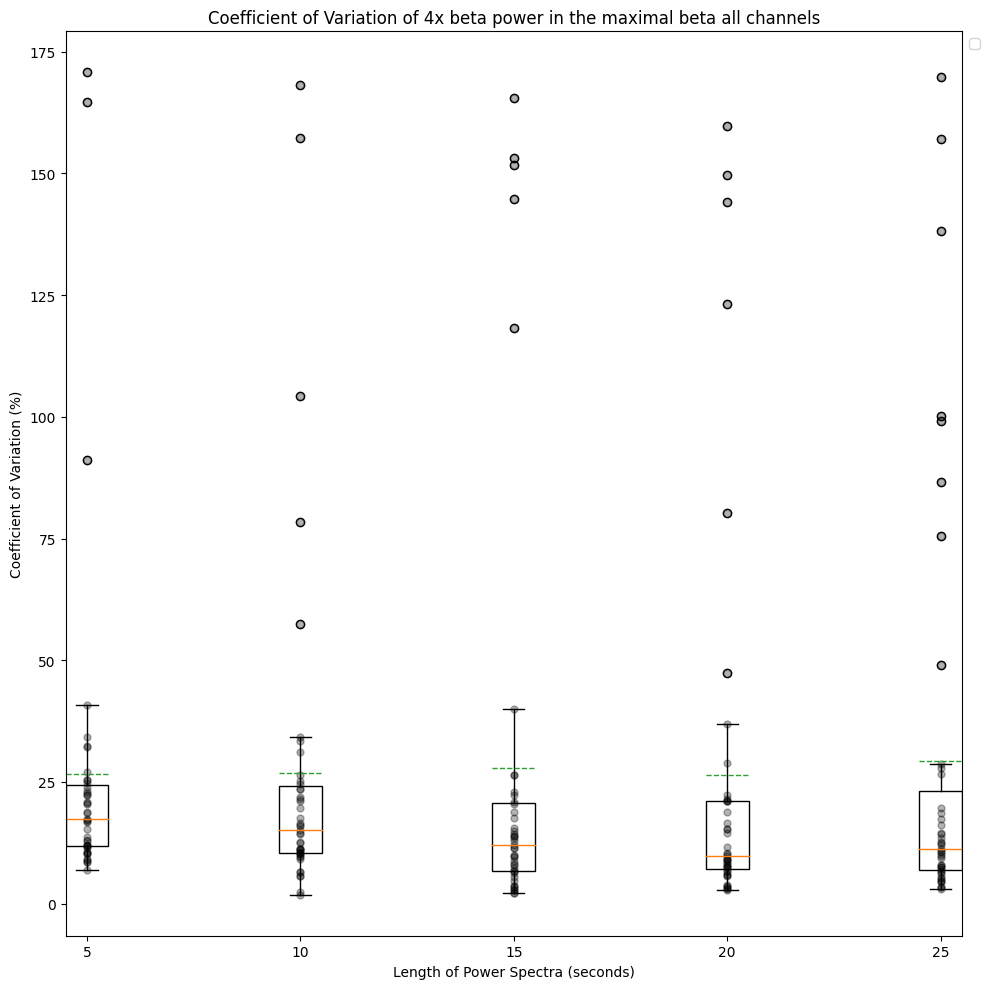

Figures Coefficient_of_Variation_4x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered.svg and Coefficient_of_Variation_4x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [59]:
plot_multiple_CV = externalized_short_chunks.plot_coefficient_of_variation_multiple_durations(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all")

In [60]:
plot_multiple_CV

,data_info,sample_size,mean_cv,std_cv,median_cv,outliers_indices,outliers_values,n_outliers,min,max,25%,50%,75%,outlier_patient_ids
0,5,43,26.725493,33.911354,17.346152,"Index([7, 18, 38], dtype='int64')","[164.64673897732916, 170.7585981353571, 91.093...",3,6.922994,170.758598,11.783022,17.346152,24.426307,"[029_Left_1B1C, 052_Right_1B2B, 077_Left_1B1C]"
1,10,43,26.766755,35.458066,15.113429,"Index([7, 18, 24, 30, 38], dtype='int64')","[157.3058184937849, 168.17298284548298, 104.32...",5,1.854376,168.172983,10.405192,15.113429,24.155170,"[029_Left_1B1C, 052_Right_1B2B, 061_Right_2A2C..."
2,15,43,27.792164,44.131933,12.069949,"Index([7, 18, 19, 24, 30], dtype='int64')","[151.7842692596665, 165.40637850296514, 153.27...",5,2.205593,165.406379,6.672902,12.069949,20.679256,"[029_Left_1B1C, 052_Right_1B2B, 052_Left_01, 0..."
3,20,43,26.344281,40.297119,9.883850,"Index([6, 7, 18, 19, 24, 30], dtype='int64')","[159.6766594725372, 144.14667898718525, 123.09...",6,2.856385,159.676659,7.025636,9.883850,21.074837,"[029_Right_2B2C, 029_Left_1B1C, 052_Right_1B2B..."
4,25,43,29.388419,42.258760,11.169497,"Index([2, 6, 7, 18, 19, 24, 35, 38], dtype='in...","[49.051008225375206, 157.0416237376785, 100.08...",8,2.956992,169.775428,6.913133,11.169497,23.207088,"[025_Right_1A2A, 029_Right_2B2C, 029_Left_1B1C..."


In [65]:
plot_multiple_CV.outlier_patient_ids.values[4]

array(['025_Right_1A2A', '029_Right_2B2C', '029_Left_1B1C',
       '052_Right_1B2B', '052_Left_01', '061_Right_2A2C',
       '075_Right_1B1C', '077_Left_1B1C'], dtype=object)

Kept data contains NaN values


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


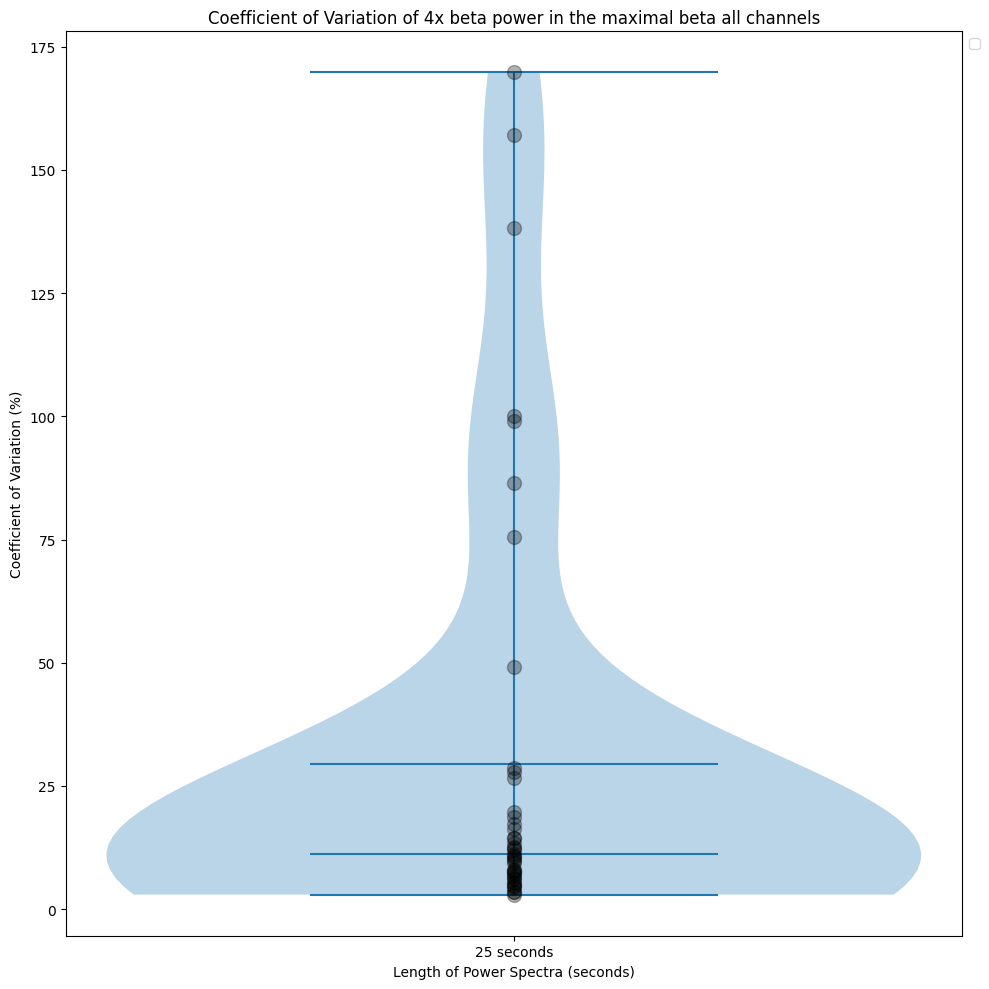

Figures Coefficient_of_Variation_4x_25sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered.svg and Coefficient_of_Variation_4x_25sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [105]:
Plot_CV = externalized_short_chunks.plot_coefficient_of_variation(filtered="notch_and_band_pass_filtered", 
                                                                  freq_band="beta", 
                                                                  channel_group="all", 
                                                                  sec_per_epoch=25)

Tukey Mean Difference Plot
- of maximal beta channels only (one channel per hemisphere)
- per hemisphere 5 x 20 sec beta power: calculate their MEAN and their DIFFERENCE TO MEAN within each hemisphere

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


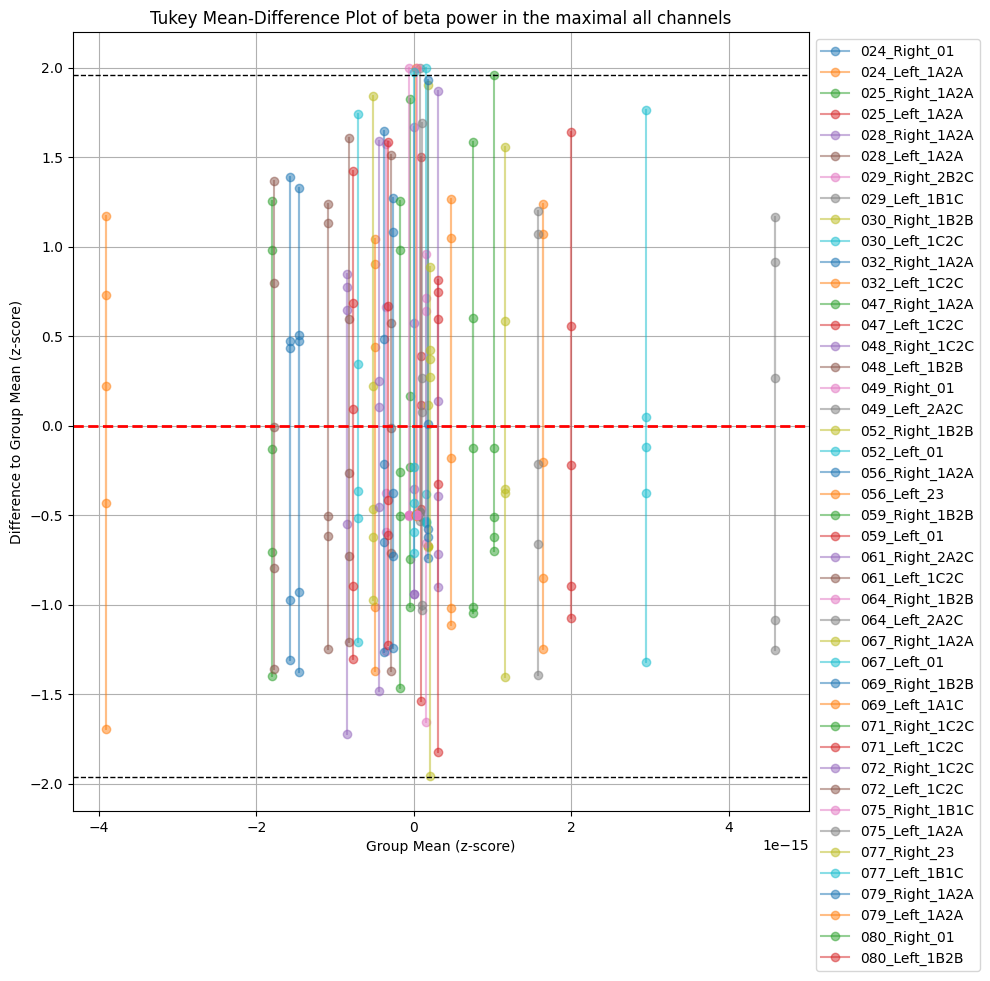

Figures Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_z_score_yes.svg and Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_z_score_yes.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [48]:
tukey_mean_difference_plot = externalized_short_chunks.tukey_mean_difference_plot(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", z_score="yes")

In [44]:
print(f"mean of all differences:{tukey_mean_difference_plot[0]}", # mean of all differences,
f"\nconfidence interval upper border:{tukey_mean_difference_plot[1]}", # confidence interval upper border
f"\nconfidence interval lower border:{tukey_mean_difference_plot[2]}", # confidence interval lower border
f"\nsample size:{tukey_mean_difference_plot[3]}") 

mean of all differences:-1.0092936587501423e-18 
confidence interval upper border:1.96 
confidence interval lower border:-1.96 
sample size:44


### Spatial Distribution: Beta rank analysis of 5x20 sec externalized BSSU recordings

Get beta ranks for each bipolar BSSU channel within each 20sec recording

In [49]:
# first get the ranked beta power of the 2 min externalized recordings
# channel group "all" = 12 BSSU channels, 12 ranks
ranked_power_2min = externalized_short_chunks.rank_power_2min(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all")

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


In [61]:
ranked_power_20sec = externalized_short_chunks.rank_20sec_power_channels(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", rank_of_interest=1)

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


In [64]:
ranked_power_20sec["all_ranked_power_20sec"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd,rank_2min,rank_20sec_1,rank_20sec_2,rank_20sec_3,rank_20sec_4,rank_20sec_5
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
1,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[9.121987733213792e-14, 8.119072538923668e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",...,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14,7.0,7.0,6.0,7.0,6.0,6.0
2,024,Right,23,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[4.667347362373837e-14, 3.287950499246578e-14,...","[4.7037840969607093e-14, 3.046466872792286e-14...","[5.154677186968955e-14, 3.881348398263996e-14,...","[4.0721243441134103e-14, 2.846600956250689e-14...","[4.678075462719349e-14, 2.810839918951721e-14,...","[4.6372324909699805e-14, 3.583766887928919e-14...",...,1.019271e-14,8.629103e-15,9.493081e-15,8.584704e-15,12.0,12.0,12.0,12.0,12.0,12.0
3,024,Right,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[2.908287511318268e-13, 2.2510070288293016e-13...","[3.066903279000984e-13, 2.3029900434534774e-13...","[4.2187079353657564e-13, 3.081934446205491e-13...","[2.0828924689717924e-13, 2.0223561911074607e-1...","[2.556445783965545e-13, 2.1375444938480986e-13...","[3.2847171119665546e-13, 2.1099923951354179e-1...",...,1.013090e-13,5.883262e-14,8.022382e-14,8.412637e-14,3.0,3.0,3.0,3.0,3.0,3.0
4,024,Right,1B2B,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[6.301136211421982e-14, 5.40385420645566e-14, ...","[5.633956542086752e-14, 6.061204692636232e-14,...","[5.824737798721049e-14, 5.052081684818284e-14,...","[4.8880123128621485e-14, 4.723724418552108e-14...","[6.372063753659436e-14, 5.017261017071023e-14,...","[6.524648436745796e-14, 4.502837294216937e-14,...",...,1.294839e-14,1.255904e-14,1.493481e-14,1.240240e-14,10.0,10.0,10.0,10.0,9.0,10.0


In [70]:
ranked_power_20sec["only_one_2min_rank_data"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd,rank_2min,rank_20sec_1,rank_20sec_2,rank_20sec_3,rank_20sec_4,rank_20sec_5
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
1,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
2,024,Left,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.0516907520203434e-12, 7.983638205046127e-13...","[1.2263824681940984e-12, 7.734967445320256e-13...","[1.269884833999199e-12, 1.0120489070157936e-12...","[8.67981539273137e-13, 5.265113974646002e-13, ...","[7.125609469947546e-13, 5.562734909884045e-13,...","[1.3972921834874141e-12, 1.1273972882628835e-1...",...,4.032693e-13,2.923844e-13,3.053879e-13,4.014941e-13,1.0,1.0,1.0,1.0,1.0,1.0
3,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
4,024,Left,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.0516907520203434e-12, 7.983638205046127e-13...","[1.2263824681940984e-12, 7.734967445320256e-13...","[1.269884833999199e-12, 1.0120489070157936e-12...","[8.67981539273137e-13, 5.265113974646002e-13, ...","[7.125609469947546e-13, 5.562734909884045e-13,...","[1.3972921834874141e-12, 1.1273972882628835e-1...",...,4.032693e-13,2.923844e-13,3.053879e-13,4.014941e-13,1.0,1.0,1.0,1.0,1.0,1.0


Tukey mean difference plot of difference of ranks of selected channels 
- select a rank of interest: channel with power rank of 2min recording

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


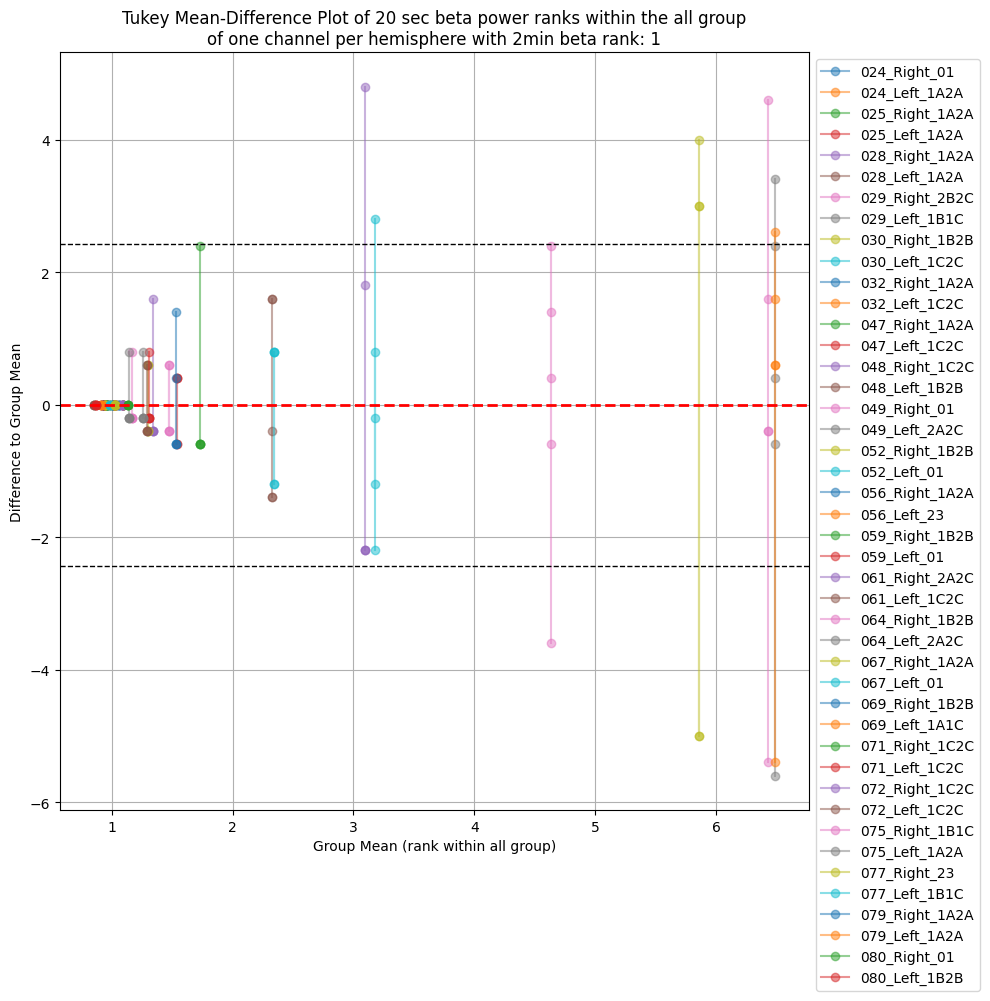

Figures Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_ranks_beta_all_notch_and_band_pass_filtered_z_score_no_of_2min_channel_rank_1.svg and Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_ranks_beta_all_notch_and_band_pass_filtered_z_score_no_of_2min_channel_rank_1.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [117]:
tukey_mean_difference_ranks = externalized_short_chunks.tukey_mean_difference_plot_20sec_ranks(
    filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", rank_of_interest=1, z_score="no")


In [116]:
print(f"mean of all differences:{tukey_mean_difference_ranks[0]}", # mean of all differences,
f"\nconfidence interval upper border:{tukey_mean_difference_ranks[1]}", # confidence interval upper border
f"\nconfidence interval lower border:{tukey_mean_difference_ranks[2]}", # confidence interval lower border
f"\nsample size:{tukey_mean_difference_ranks[3]}") 

mean of all differences:1.0092936587501423e-18 
confidence interval upper border:1.2536202121709894 
confidence interval lower border:-1.2536202121709894 
sample size:44
